# Application 1: Showcase 

In [1]:
from ssm4epi.models.regional_growth_factor import (
    key,
    n_iterations,
    N_mle,
    N_meis,
    N_posterior,
    percentiles_of_interest,
    make_aux,
    dates_full,
    cases_full,
    n_ij,
    n_tot,
    n_pop,
    account_for_nans,
    growth_factor_model,
)

import jax.numpy as jnp
import jax
import jax.random as jrn

from isssm.importance_sampling import prediction
from isssm.laplace_approximation import laplace_approximation as LA
from isssm.modified_efficient_importance_sampling import (
    modified_efficient_importance_sampling as MEIS,
)

from pyprojroot.here import here

jax.config.update("jax_enable_x64", True)
from isssm.estimation import initial_theta
import pickle
import matplotlib.pyplot as plt

In [2]:
from datetime import date
import pandas as pd

initial_date = "2020-04-18"
np1 = 10
(dates_index,) = jnp.where(dates_full == initial_date)[0]
dates = dates_full[dates_index + 1 : dates_index + np1 + 1]
aux = make_aux(initial_date, cases_full, n_ij, n_tot, np1)

y = aux[0][1:]
y_nan = y.at[-1].set(jnp.nan)
missing_inds = jnp.isnan(y_nan)
# original result from 10_model.ipynb
theta_manual = jnp.array(
    [-0.0236392, -2.0838978, -5.31651543, -2.62109273, -0.3461143, 0.57673125]
)
_, y_miss = account_for_nans(
    growth_factor_model(theta_manual, aux), y_nan, missing_inds
)
_model_miss = lambda theta, aux: account_for_nans(
    growth_factor_model(theta, aux), y_nan, missing_inds
)[0]

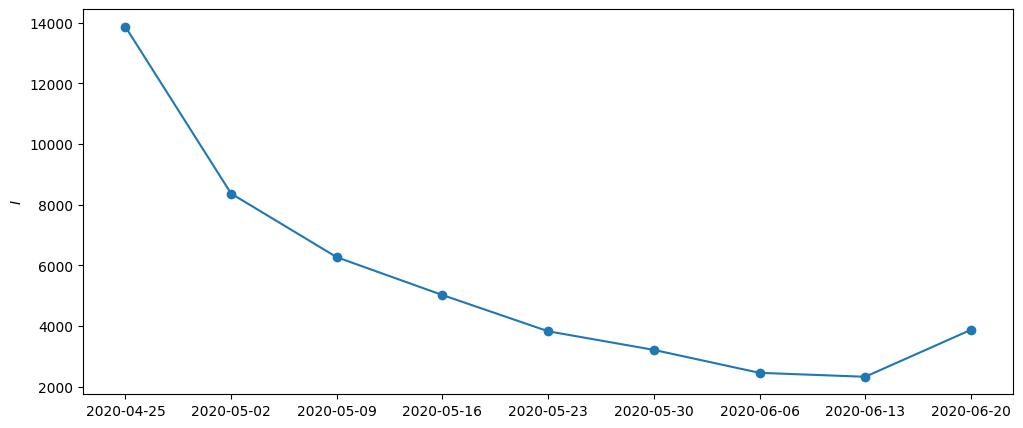

In [3]:
plt.figure(figsize=(12, 5))
plt.ylabel("$I$")
plt.plot(dates, y_nan.sum(axis=-1))
plt.scatter(dates, y_nan.sum(axis=-1))
plt.show()

In [4]:
theta0_result = initial_theta(
    y_miss,
    _model_miss,
    theta_manual,
    aux,
    n_iter_la=n_iterations,
    options={"maxiter": 10},
)
theta0 = theta0_result.x

In [5]:
from ssm4epi.models.regional_growth_factor import theta_to_par
import jax.scipy as jsp

jsp.special.expit(theta0[0]) * 2 - 1

Array(-0.01538746, dtype=float64)

In [6]:
from isssm.laplace_approximation import laplace_approximation
from isssm.estimation import pgnll
from scipy.optimize import minimize as minimize_scipy
from jaxtyping import Float, Array
from jax import jit


def mle_pgssm(
    y: Float[Array, "n+1 p"],  # observations $y_t$
    model_fn,  # parameterized LCSSM
    theta0: Float[Array, "k"],  # initial parameter guess
    aux,  # auxiliary data for the model
    n_iter_la: int,  # number of LA iterations
    N: int,  # number of importance samples
    key: Array,  # random key
    options=None,  # options for the optimizer
) -> Float[Array, "k"]:  # MLE
    """Maximum Likelihood Estimation for PGSSMs"""

    @jit
    def f(theta, key):
        model = model_fn(theta, aux)

        proposal_la, _ = laplace_approximation(y, model, n_iter_la)

        key, subkey = jrn.split(key)
        # improve numerical stability by dividing by number of observations
        n_obs = y.size
        return pgnll(y, model, proposal_la.z, proposal_la.Omega, N, subkey) / n_obs

    key, subkey = jrn.split(key)
    result = minimize_scipy(
        f, theta0, method="BFGS", jac="3-point", options=options, args=(subkey,)
    )
    return result


theta_result = mle_pgssm(
    y_miss,
    _model_miss,
    theta0,
    aux,
    n_iter_la=n_iterations,
    N=10000,
    key=key,
    options={"maxiter": 100},
)
theta = theta_result.x
theta_result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 2.5437482153776516
        x: [-4.432e-01 -3.458e+00 -2.887e-01 -2.959e+00  3.409e-01
             2.971e+00]
      nit: 56
      jac: [-5.860e-06  2.659e-06  4.936e-06  1.273e-06  4.085e-06
            -1.754e-06]
 hess_inv: [[ 1.907e+01  4.070e+00 ... -1.014e+01  1.162e+01]
            [ 4.070e+00  1.223e+03 ...  8.433e-02  4.541e+01]
            ...
            [-1.014e+01  8.433e-02 ...  6.092e+01  3.498e+01]
            [ 1.162e+01  4.541e+01 ...  3.498e+01  4.599e+02]]
     nfev: 858
     njev: 66

In [8]:
fitted_model = _model_miss(theta, aux)
proposal_la, info_la = LA(y_miss, fitted_model, n_iterations)


def f_pred(x, s, y):
    y_county = y[-1]
    y_tot = jnp.minimum(y_county, n_pop).sum()[None]

    growth_factor = x[:, 0]
    growth_factors_county = s.reshape(-1)
    return jnp.concatenate([y_tot, y_county, growth_factors_county, growth_factor])


key, subkey = jrn.split(key)

In [41]:
preds = prediction(
    f_pred,
    y_miss,
    proposal_la,
    fitted_model,
    100,
    subkey,
    percentiles_of_interest,
    growth_factor_model(theta, aux),
)

result = (theta, proposal_la, preds, dates, y)

with open(here() / "data/results/4_local_outbreak_model/results.pickle", "wb") as f:
    pickle.dump(result, f)

In [42]:
preds[2][:, 0]

Array([2261.5304789 , 2842.37185041, 3605.15148285, 3605.47859834,
       3605.80571384, 3606.13282933, 3606.45994483, 3606.78706032,
       3607.11417581, 3607.44129131, 3607.7684068 , 4148.85810806,
       4720.33087078, 4720.8185383 , 4721.30620582, 4721.79387334,
       4722.28154086, 4722.76920838, 4723.2568759 , 4723.74454342,
       5012.9002042 , 5277.68991699, 5281.09104275], dtype=float64)

In [43]:
with open(here() / "data/results/4_local_outbreak_model/results.pickle", "rb") as f:
    result = pickle.load(f)

In [44]:
theta, proposal, preds, dates, y = result

In [45]:
from ssm4epi.models.regional_growth_factor import _P
import jax.scipy as jsp

logit_alpha, log_s2_r, log_s2_spat, logit_q, log_Cm1, log_r = theta

params_ser = pd.Series(
    {
        "alpha": jsp.special.expit(logit_alpha) * 2 - 1,
        "sigma_r": jnp.sqrt(jnp.exp(log_s2_r)),
        "sigma spatial": jnp.sqrt(jnp.exp(log_s2_spat)),
        "q": jsp.special.expit(logit_q),
        "C": jnp.exp(log_Cm1) + 1,
        "r": jnp.exp(log_r),
    }
)
params_ser.to_csv(
    here() / "data/results/4_local_outbreak_model/estimated_parameters.csv",
    header=False,
)
params_ser.apply(lambda x: f"{x:.2f}")

alpha            -0.22
sigma_r           0.18
sigma spatial     0.87
q                 0.05
C                 2.41
r                19.52
dtype: object

In [46]:
import numpy as np

P = _P(params_ser.C, params_ser.q, n_ij, n_tot)

np.savetxt(
    here() / "data/results/4_local_outbreak_model/showcase_P_matrix.csv", np.array(P)
)

In [47]:
import pandas as pd

df = pd.DataFrame(
    {
        "variable": [
            "y_total",
            *[f"y_total_{c}" for c in range(1, 401)],
            *[f"log_rho_{c}_{t}" for t in range(1, 11) for c in range(1, 401)],
            *["log_rho" for t in range(1, 11)],
        ],
        "c": [
            0,
            *range(1, 401),
            *[c for t in range(1, 11) for c in range(1, 401)],
            *[0 for _ in range(1, 11)],
        ],
        "t": [
            10,
            *jnp.repeat(10, 400),
            *[t for t in range(1, 11) for c in range(1, 401)],
            *[t for t in range(1, 11)],
        ],
        "mean": preds[0],
        "sd": preds[1],
        **{
            f"{p * 100:.1f} %": preds[2][i, :]
            for i, p in enumerate(percentiles_of_interest)
        },
    }
)

df["date"] = [dates[t - 1] for t in df["t"]]
df.to_csv(here("data/results/4_local_outbreak_model/showcase.csv"), index=False)